This code is written to ingest WM811K dataset and get trained on defect patterns and be able to distinguish and group wafers into two groups - defect pattern vs no pattern. Data has some added data points to rebalance class and has much better accuracy.

Sources:
1. Keras Wafer Classification 2D: TEEEADY https://www.kaggle.com/teeeady/keras-wafer-classification-cnn2d


In [4]:
import os
from os.path import join

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings

!pip install tensorflow
import tensorflow as tf
import keras
from keras import layers, Input, models
from tensorflow.keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from tensorflow.keras import datasets, layers, models, losses

# Import modeling libraries.
import sklearn as sk
#sklearn.__version__
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from skimage.transform import resize as sk_resize

datapath = join('data', 'wafer')

warnings.filterwarnings("ignore")

In [5]:
# Read the full data file that is stored locally. Look at information and data details

df=pd.read_pickle("LSWMD.pkl")
df.info()
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
466678,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2,...",712.0,lot28697,6.0,[],[]
436484,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1507.0,lot26406,23.0,[],[]
396292,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3777.0,lot23711,25.0,[],[]
176966,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2393.0,lot11316,21.0,[],[]
724144,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,...",518.0,lot43996,14.0,[[Test]],[[none]]


In [19]:
#Data Pre-Processing

# image size drop
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1

# Data preprocessing process
def __Inputdf__(Height, Width):
    sub_df = df.loc[df['waferMapDim'] == (Height, Width)]
    sw = np.ones((1,  Height, Width))
    label = list()

    for i in range(len(sub_df)):
        if len(sub_df.iloc[i, :]['failureType']) == 0:
            continue
        sw = np.concatenate((sw, sub_df.iloc[i,:]['waferMap'].reshape(1, Height, Width)))
        label.append(sub_df.iloc[i, :]['failureType'][0][0])
    
    x = sw[1:]
    y = np.array(label).reshape((-1,1))
    
    #add channel
    x = x.reshape((-1, Height, Width, 1))
    new_x = np.zeros((len(x), Height, Width, 3))

    for w in range(len(x)):
        for i in range(Height):
            for j in range(Width):
                new_x[w, i, j, int(x[w, i, j])] = 1
    return new_x, y

# Two ways to Scaling
def __InputTf1__(new_x):
    new_result = tf.compat.v1.image.resize(new_x, (26,26),
                                           method=tf.image.ResizeMethod.NEAREST_NEIGHBOR, 
                                           align_corners=True,
                                           preserve_aspect_ratio=False, name=None)
    return new_result

def __InputTf2__(new_x):
    new_result = tf.keras.preprocessing.image.smart_resize(new_x, (26,26),
                                                           interpolation = 'nearest')
    return new_result

# augment function define
def gen_data(wafer, label):
    # Encode input wafer
    encoded_x = encoder.predict(wafer)
    
    # dummy array for collecting noised wafer
    gen_x = np.zeros((1, 26, 26, 3))
    
    # Make wafer until total # of wafer to 2000
    for i in range((2000//len(wafer)) + 1):
        noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64)) 
        noised_gen_x = decoder.predict(noised_encoded_x)
        gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
    # also make label vector with same length
    gen_y = np.full((len(gen_x), 1), label)
    
    # return date without 1st dummy data.
    return gen_x[1:], gen_y[1:]

 # Saving and loading new_x and new_y variables
def save_new_x(new_x):
    f = open("./save_new_x.csv", "w")
    for w in range(len(new_x)):
        for i in range(26):
            for j in range(26):
                for o in range(3):
                    f.write(str(new_x[w][i][j][o]))
                
    f.close()
    return 

#Save it as a csv file and take it out again to learn because of the lack of maximum memory inside Kaggle.  

In [14]:
#We do not need wafer index in our model. Dropping it
df = df.drop(['waferIndex'], axis = 1)

#Since wafer maps have different data lengths, find dimensions
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
105067,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,...",1109.0,lot7173,[],[],"(39, 37)"
165823,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,...",533.0,lot10598,[],[],"(26, 26)"
800454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2,...",562.0,lot47093,[[Test]],[[none]],"(29, 26)"
167674,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",572.0,lot10681,[],[],"(22, 35)"
290364,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",5139.0,lot17782,[],[],"(81, 81)"


Get sub wafer with resolution.

Wafer is resized to have (26, 26) resolution. rearrange wafer nd-array with faulty case label. some wafer has null label, skip it. First, let's create two types of resolution data by combining them.

In [20]:
%%time
new_x1, y1 = __Inputdf__(26, 26)
new_x2, y2 = __Inputdf__(25, 27)

CPU times: user 9min 51s, sys: 10min 22s, total: 20min 14s
Wall time: 20min 19s


In [22]:
#Resized using Compat.V1 Pre-processing method¶

new_Tf1_1 = __InputTf1__(new_x1)
new_Tf2_1 = __InputTf1__(new_x2)

In [23]:
# y = y1 + y2
y = np.concatenate((y1, y2), axis=0)
# new_x = new_x1 + new_x2
new_x= tf.concat([new_Tf1_1, new_Tf2_1], 0)

In [24]:
# Using random sampling as a y array to put the none value into the none_idx variable
none_idx = np.where(y=='none')[0][np.random.choice(len(np.where(y=='none')[0]), size=11000, replace=False)]

# delete the none value
new_x = np.delete(new_x, none_idx, axis=0)
new_y = np.delete(y, none_idx, axis=0)

faulty_case = np.unique(y)
# make string label data to numerical data
for i, l in enumerate(faulty_case):
    new_y[new_y==l] = i
    
# one-hot-encoding
new_y = to_categorical(new_y)

In [25]:
# split data train, test
x_train, x_test, y_train, y_test = train_test_split(new_x,new_y,test_size=0.33,random_state=2021)

In [26]:
print('Train x : {}, y : {}'.format(x_train.shape, y_train.shape))
print('Test x: {}, y : {}'.format(x_test.shape, y_test.shape))

Train x : (14838, 26, 26, 3), y : (14838, 9)
Test x: (7309, 26, 26, 3), y : (7309, 9)


In [32]:
# parameter
epoch=10
batch_size=1024

In [33]:
def create_model():
    input_shape = (26, 26, 3)
    input_tensor = Input(input_shape)

    conv_1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input_tensor)

    flat = layers.Flatten()(conv_1)

    dense_1 = layers.Dense(16, activation='relu')(flat)
    output_tensor = layers.Dense(9, activation='softmax')(dense_1)

    model = models.Model(input_tensor, output_tensor)
    model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

    return model

In [34]:
# Make keras model to sklearn classifier.
model = KerasClassifier(build_fn=create_model, epochs=5, batch_size=2048, verbose=2) 
# 3-Fold Crossvalidation
kfold = KFold(n_splits=3, shuffle=True, random_state=2019) 
results = cross_val_score(model, x_train, y_train, cv=kfold)
# Check 3-fold model's mean accuracy
print('Simple CNN Cross validation score : {:.4f}'.format(np.mean(results)))

Epoch 1/5
5/5 - 1s - loss: 1.1934 - accuracy: 0.6629 - 811ms/epoch - 162ms/step
Epoch 2/5
5/5 - 0s - loss: 0.6207 - accuracy: 0.8291 - 453ms/epoch - 91ms/step
Epoch 3/5
5/5 - 0s - loss: 0.5589 - accuracy: 0.8303 - 452ms/epoch - 90ms/step
Epoch 4/5
5/5 - 0s - loss: 0.4872 - accuracy: 0.8382 - 458ms/epoch - 92ms/step
Epoch 5/5
5/5 - 0s - loss: 0.4234 - accuracy: 0.9164 - 464ms/epoch - 93ms/step
3/3 - 0s - loss: 0.4510 - accuracy: 0.9234 - 244ms/epoch - 81ms/step
Epoch 1/5
5/5 - 1s - loss: 1.1455 - accuracy: 0.6680 - 801ms/epoch - 160ms/step
Epoch 2/5
5/5 - 0s - loss: 0.7389 - accuracy: 0.8267 - 472ms/epoch - 94ms/step
Epoch 3/5
5/5 - 0s - loss: 0.5691 - accuracy: 0.8275 - 477ms/epoch - 95ms/step
Epoch 4/5
5/5 - 0s - loss: 0.4703 - accuracy: 0.8619 - 468ms/epoch - 94ms/step
Epoch 5/5
5/5 - 0s - loss: 0.4239 - accuracy: 0.8964 - 454ms/epoch - 91ms/step
3/3 - 0s - loss: 0.3870 - accuracy: 0.8995 - 206ms/epoch - 69ms/step
Epoch 1/5
5/5 - 1s - loss: 1.3747 - accuracy: 0.6577 - 1s/epoch - 210m

In [35]:
history = model.fit(x_train, y_train,validation_data=(x_test, y_test),epochs=epoch,batch_size=batch_size)

Epoch 1/10
15/15 - 1s - loss: 0.7746 - accuracy: 0.8147 - val_loss: 0.5290 - val_accuracy: 0.8353 - 1s/epoch - 96ms/step
Epoch 2/10
15/15 - 1s - loss: 0.4589 - accuracy: 0.8924 - val_loss: 0.3722 - val_accuracy: 0.9278 - 1s/epoch - 68ms/step
Epoch 3/10
15/15 - 1s - loss: 0.3475 - accuracy: 0.9282 - val_loss: 0.3135 - val_accuracy: 0.9302 - 997ms/epoch - 66ms/step
Epoch 4/10
15/15 - 1s - loss: 0.3041 - accuracy: 0.9287 - val_loss: 0.2879 - val_accuracy: 0.9304 - 990ms/epoch - 66ms/step
Epoch 5/10
15/15 - 1s - loss: 0.2806 - accuracy: 0.9292 - val_loss: 0.2696 - val_accuracy: 0.9305 - 978ms/epoch - 65ms/step
Epoch 6/10
15/15 - 1s - loss: 0.2593 - accuracy: 0.9297 - val_loss: 0.2551 - val_accuracy: 0.9309 - 993ms/epoch - 66ms/step
Epoch 7/10
15/15 - 1s - loss: 0.2417 - accuracy: 0.9310 - val_loss: 0.2429 - val_accuracy: 0.9320 - 1s/epoch - 67ms/step
Epoch 8/10
15/15 - 1s - loss: 0.2243 - accuracy: 0.9320 - val_loss: 0.2337 - val_accuracy: 0.9345 - 989ms/epoch - 66ms/step
Epoch 9/10
15/15 

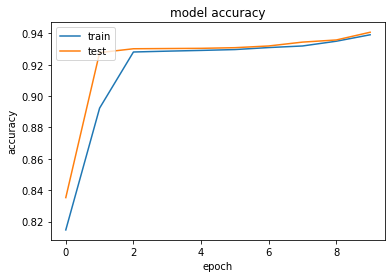

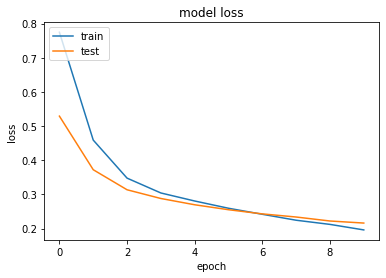

In [36]:
# accuracy plot 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()